## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---

In [1]:
import numpy as np
import cv2
import PyQt5
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import pickle

import glob

In [2]:
# to display full output of all commands, not only last result
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last"

# Camera calibration

In [3]:
# using chessboard images
def get_object_and_img_points(images, nx, ny):
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((ny * nx, 3), np.float32)
    objp[:, :2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)

    # Arrays to store object points and image points from all the images.
    objpoints = []  # 3d points in real world space
    imgpoints = []  # 2d points in image plane.

    # Step through the list and search for chessboard corners
    for fname in images:
        img = mpimg.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

        # If found, add object points, image points
        if ret:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            cv2.drawChessboardCorners(img, (nx, ny), corners, ret)            

    return objpoints, imgpoints


def calibrate_camera(objpoints, imgpoints, img_size):
    # Do camera calibration given object points and image points
    _, mtx, dist, _, _ = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

    # return camera matrix and distortion coefficients
    return mtx, dist

In [4]:
# Make a list of calibration images
chessboard_images = glob.glob('./camera_cal/calibration*.jpg')
nx, ny = 9, 6

objpoints, imgpoints = get_object_and_img_points(chessboard_images, nx, ny)

test_img = mpimg.imread('./camera_cal/calibration1.jpg')
print(test_img.shape)
img_size = test_img.shape[1::-1]
print("image size: {}".format(img_size))

# Save the camera calibration result for later use
mtx, dist = calibrate_camera(objpoints, imgpoints, img_size)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "./camera_cal/wide_dist_pickle.p", "wb" ) )

print('camera calibrated')

(720, 1280, 3)
image size: (1280, 720)
camera calibrated


## Distortion correction

In [5]:
def undistort_img(image, mtx, dist, dst=None, newmtx):
    assert len(image.shape) == 3
    undist = cv2.undistort(image, mtx, dist, dst, newmtx)

    return undist

### test the calibration

In [7]:
# Read in the saved camera matrix and distortion coefficients
# These are the arrays you calculated using cv2.calibrateCamera()
dist_pickle = pickle.load( open( "./camera_cal/wide_dist_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

(<matplotlib.axes._subplots.AxesSubplot at 0x1133b6c50>,
 Text(0.5,1,'undistorted'))

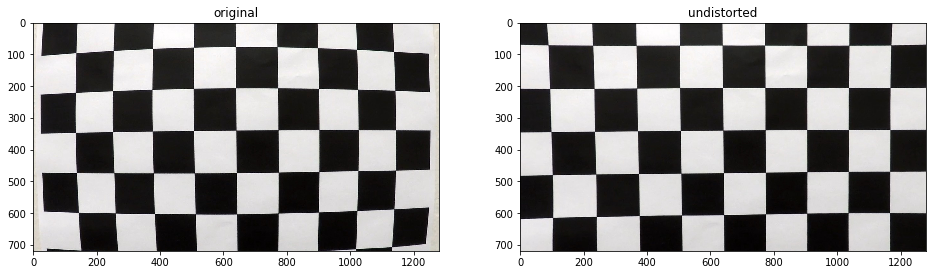

In [9]:
%matplotlib inline

test_img = mpimg.imread('./camera_cal/calibration1.jpg')
undist_img = undistort_img(test_img, mtx, dist, None, mtx)

plt.figure(figsize=(16,10))
plt.subplot(121), plt.imshow(test_img), plt.title('original')
plt.subplot(122), plt.imshow(undist_img), plt.title('undistorted')

# Image thresholding

## Sobel gradient thresholds

In [10]:
# Define a function that applies Sobel x or y,
# then takes an absolute value of the gradient and applies a threshold.
def sobel_absolute_threshold(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    
    # 1) check one channel
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    assert len(img.shape) == 2

    # Apply cv2.Sobel()
    if orient == 'x':
        sobel = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    elif orient == 'y':
        sobel = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    # Take the absolute value of the output from cv2.Sobel()
    abs_sobel = np.absolute(sobel)

    # Scale the result to an 8-bit range (0-255)
    scale = np.max(abs_sobel) / 255
    scaled_sobel = np.uint8(abs_sobel / scale)

    # Create a binary mask where the scaled gradient magnitude is > thresh_min and < thresh_max
    binary_output = np.zeros_like(scaled_sobel)

    # Apply lower and upper thresholds
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Create binary_output
    return binary_output

In [11]:
# Define a function that applies Sobel x and y,
# then computes the magnitude of the gradient and applies a threshold
def sobel_magnitude_threshold(img, sobel_kernel=3, thresh=(0, 255)):

    # Apply the following steps to img
    # 1) check one channel
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    assert len(img.shape) == 2

    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    # 3) Calculate the magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)

    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scale_factor = np.max(gradmag) / 255
    gradmag = (gradmag / scale_factor).astype(np.uint8)

    # 5) Create a binary mask where mag thresholds are met
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= thresh[0]) & (gradmag <= thresh[1])] = 1

    # 6) Return this mask as your binary_output image
    return binary_output

In [12]:
# Define a function that applies Sobel x and y,
# then computes the direction of the gradient and applies a threshold.
def sobel_direction_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):

    # Apply the following steps to img
    # 1) check one channel
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    assert len(img.shape) == 2
    
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)

    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient
    graddir = np.arctan2(abs_sobely, abs_sobelx)

    # 5) Create a binary mask where direction thresholds are met
    binary_output = np.zeros_like(graddir)
    binary_output[(graddir >= thresh[0]) & (graddir <= thresh[1])] = 1

    # 6) Return this mask as your binary_output image
    return binary_output

## Color space threshold for HSV and HLS

In [13]:
# Define a function that thresholds the S-channel of HLS and V-channel of HSV
def color_threshold(image, s_thresh=(0, 255), v_thresh=(0, 255)):
    
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)

    # 2) Apply a threshold to the S channel
    s_channel = hls[:, :, 2]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel > s_thresh[0]) & (s_channel <= s_thresh[1])] = 1

    # 1) Convert to HLS color space
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

    # 2) Apply a threshold to the S channel
    v_channel = hsv[:, :, 2]
    v_binary = np.zeros_like(v_channel)
    v_binary[(v_channel > v_thresh[0]) & (v_channel <= v_thresh[1])] = 1

    binary_output = np.zeros_like(s_channel)
    binary_output[(s_binary==1) & (v_binary==1)] = 1

    return binary_output

## Image Thresholding pipeline

In [23]:
# Edit this function to create your own pipeline.
def img_thresholding_pipeline(image):
    img = np.copy(image)
    assert len(img.shape) == 3

    # Convert to HLS color space and separate the V channel
#     hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
#     l_channel = hls[:, :, 1]
#     s_channel = hls[:, :, 2]

    # Sobel gradient thresholds
    gradx = sobel_absolute_threshold(img, orient='x', sobel_kernel=3, thresh=(12, 255))
    grady = sobel_absolute_threshold(img, orient='y', sobel_kernel=3, thresh=(25, 255))
    dir_binary = sobel_magnitude_threshold(img, sobel_kernel=15, thresh=(0.7, 1.3))
    mag_binary = sobel_direction_threshold(img, sobel_kernel=3, thresh=(30, 100))
    col_binary = color_threshold(img, s_thresh=(100, 255), v_thresh=(50, 255))    
    
    # Stack each channel
    color_binary = np.dstack((np.zeros_like(gradx), gradx, col_binary)) * 255
#     color_binary = np.dstack((np.zeros_like(gradx), gradx, col_binary))

    # Combine the binary thresholds
    combined_binary = np.zeros_like(dir_binary)
    combined_binary[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1)) | (col_binary == 1)] = 255

    return color_binary, combined_binary

### test image thresholding pipeline

(<matplotlib.axes._subplots.AxesSubplot at 0x121926fd0>,
 Text(0.5,1,'combined binary'))

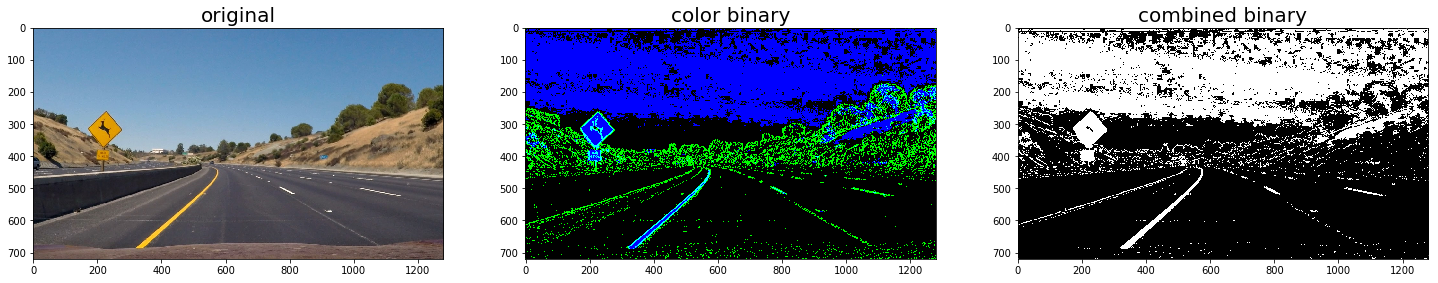

In [24]:
%matplotlib inline

test_img = mpimg.imread('./test_images/test2.jpg')
color_binary, combined_binary = img_thresholding_pipeline(test_img)

plt.figure(figsize=(25,10))
plt.subplot(131), plt.imshow(test_img), plt.title('original', fontsize=20)
plt.subplot(132), plt.imshow(color_binary, cmap='gray'), plt.title('color binary', fontsize=20)
plt.subplot(133), plt.imshow(combined_binary, cmap='gray'), plt.title('combined binary', fontsize=20)

# Perspective transform

In [25]:
def get_perspective_transform(image):
    h, w = image.shape[:2]

    # define source and destination points for transform
    src = np.float32([[0,h-30], [w,h-30], [730,460], [540,460]])  # from bottom left, counter-clockwise
    dst = np.float32([[0,h], [w,h], [w,0], [0,0]])  # in the same order as src

#     src = np.float32(
#         [[(w / 2) - 55, h / 2 + 100],
#         [((w / 6) - 10), h],
#         [(w * 5 / 6) + 60, h],
#         [(w / 2 + 55), h / 2 + 100]])
#     dst = np.float32(
#         [[(w / 4), 0],
#         [(w / 4), h],
#         [(w * 3 / 4), h],
#         [(w * 3 / 4), 0]])
        
    img_size = (image.shape[1], image.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    M_inv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(image, M, img_size, flags=cv2.INTER_LINEAR)
    
    return warped, M_inv

### test perspective transform

(<matplotlib.axes._subplots.AxesSubplot at 0x1242ae668>,
 Text(0.5,1,'warped'))

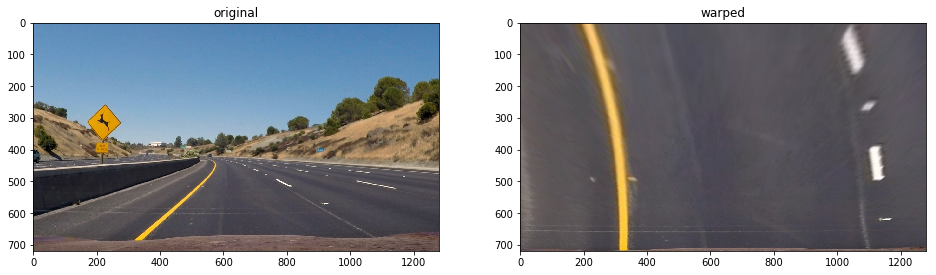

In [26]:
%matplotlib inline

test_img = mpimg.imread('./test_images/test2.jpg')
warped_img = get_perspective_transform(test_img)[0]

plt.figure(figsize=(16,10))
plt.subplot(121), plt.imshow(test_img), plt.title('original')
plt.subplot(122), plt.imshow(warped_img, cmap='gray'), plt.title('warped')

## Image Preprocessing pipeline

In [27]:
def img_preprocessing_pipeline(image, mtx, dist, viz=False):
    # undistort image
    undist_img = undistort_img(image, mtx, dist, None, mtx)

    # get binary image of values 0 and 1
    color_binary, combined_binary = img_thresholding_pipeline(undist_img)
    
    # perspective transform
    warped_img, M_inv = get_perspective_transform(combined_binary)
    
    if viz:
        return undist_img, color_binary, combined_binary, warped_img, M_inv
    else:
        return warped_img, M_inv

# Lane detection

### Tracker for left and right lanes

In [28]:
class Tracker():
    def __init__(self, win_width=50, win_height=80, margin=100, ym=10/720, xm=4/384, smooth_factor=15):
        self._recent_centers = []  # past (left, right) center values for smoothening
        self._win_width = win_width  # window pixel width of center values
        self._win_height = win_height  # window pixel height of center values
        self._margin = margin  # pixel distance for template searching
        self._ym_per_pix = ym  # meters per pixel in y
        self._xm_per_pix = xm  # meters per pixel in x
        self._smooth_factor = smooth_factor

    def find_window_centroids(self, warped):
        img = np.copy(warped)
        h, w = img.shape[:2]

        window_width = self._win_width
        window_height = self._win_height
        margin = self._margin

        window_centroids = []  # Store the (left,right) window centroid positions per level
        window = np.ones(window_width)  # Create our window template that we will use for convolutions

        # First find the two starting positions for the left and right lanes
        # by using np.sum to get the vertical image slice
        # and then np.convolve the vertical image slice with the window template

        # Sum quarter bottom of image to get slice, could use a different ratio
        l_sum = np.sum(img[int(3*h/4):, :int(w/2)], axis=0)
        l_center = np.argmax(np.convolve(window,l_sum)) - window_width/2
        r_sum = np.sum(img[int(3*h/4):, int(w/2):], axis=0)
        r_center = np.argmax(np.convolve(window,r_sum)) - window_width/2 + int(w/2)

        # Add what we found for the first layer
        window_centroids.append((l_center,r_center))
        
        old_l_center = l_center

        # Go through each layer looking for max pixel locations
        for level in range(1,(int)(h/window_height)):
            
            # convolve the window into the vertical slice of the image
            img_layer = np.sum(img[int(h-(level+1)*window_height):int(h-level*window_height), :], axis=0)
            conv_signal = np.convolve(window, img_layer)
            
            # Find the best left centroid by using past left center as a reference
            # Use window_width/2 as offset because convolution signal reference is at right side of window,
            # not center of window
            offset = window_width/2
            l_min_index = int(max(l_center+offset-margin, 0))
            l_max_index = int(min(l_center+offset+margin, w))
            l_center = np.argmax(conv_signal[l_min_index:l_max_index]) + l_min_index - offset
            
            # Find the best right centroid by using past right center as a reference
            r_min_index = int(max(r_center+offset-margin, 0))
            r_max_index = int(min(r_center+offset+margin, w))
            r_center = np.argmax(conv_signal[r_min_index:r_max_index]) + r_min_index - offset
            
            # Append to centroid array
            if abs(old_l_center-l_center)>200:
                l_center = old_l_center
            else:
                old_l_center = l_center
            
            # Add what we found for that layer
            window_centroids.append((l_center, r_center))

        self._recent_centers.append(window_centroids)

        # return avg values of the line centers, for smoothening
        return np.average(self._recent_centers[-self._smooth_factor:], axis=0)

## Sliding window using Convolution approach

In [29]:
def get_window_mask(window_width, window_height, img_ref, window_center, level):
    output = np.zeros_like(img_ref)
    h, w = img_ref.shape[:2]
    
    m = int(h - (level+1)*window_height)
    n = int(h - level*window_height)
    p = max(0, int(window_center - window_width/2))
    q = min(int(window_center+window_width/2), w)
    output[m:n, p:q] = 1

    return output

In [30]:
def sliding_window_using_convolution(warped, window_centroids, window_width, window_height):
    # If we found any window centers
    if len(window_centroids) > 0:

        # Points used to draw all the left and right windows
        l_points = np.zeros_like(warped)
        r_points = np.zeros_like(warped)
        
        # points used to find left and right lanes
        leftx, rightx = [], []

        # Go through each level and draw the windows
        for level in range(0, len(window_centroids)):
            
            # get_window_mask is a function to draw window areas
            l_mask = get_window_mask(window_width, window_height, warped, window_centroids[level][0], level)
            r_mask = get_window_mask(window_width, window_height, warped, window_centroids[level][1], level)
            
            leftx.append(window_centroids[level][0])
            rightx.append(window_centroids[level][1])
            
            # Add graphic points from window mask here to total pixels found
            l_points[(l_points == 255) | (l_mask == 1)] = 255
            r_points[(r_points == 255) | (r_mask == 1)] = 255

        # Draw the results, for visual debugging
        template = np.array(r_points+l_points, np.uint8)  # add both left and right window pixels together
        zero_channel = np.zeros_like(template)  # create a zero color channel
        template = np.array(cv2.merge((zero_channel, template, zero_channel)), np.uint8)  # make window pixels green
        warpage = np.array(cv2.merge((warped, warped, warped)), np.uint8)  # making the original road pixels 3 color channels
        output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0)  # overlay the orignial road image with window results
    # If no window centers found, just display orginal road image
    else:
        output = np.array(cv2.merge((warped, warped, warped)), np.uint8)

    return output, leftx, rightx


## Fitting polynomial to the lanes

In [45]:
def fit_lane_boundaries(warped, window_width, window_height, leftx, rightx):
    h, w = warped.shape[:2]
    
    yvals = range(0, h)
    res_yvals = np.arange(h-window_height/2, 0, -window_height)

    # fit polynomial to left lane
    left_fit = np.polyfit(res_yvals, leftx, 2)
    left_fitx = left_fit[0]*np.power(yvals,2) + left_fit[1]*yvals + left_fit[2]
    left_fitx = np.array(left_fitx, np.int32)
    left_lane = np.array(list(zip(np.concatenate((left_fitx-window_width/2, left_fitx[::-1]+window_width/2), axis=0), np.concatenate((yvals, yvals[::-1]), axis=0))), np.int32)

    # fit polynomial to right lane
    right_fit = np.polyfit(res_yvals, rightx, 2)
    right_fitx = right_fit[0]*np.power(yvals,2) + right_fit[1]*yvals + right_fit[2]
    right_fitx = np.array(right_fitx, np.int32)
    right_lane = np.array(list(zip(np.concatenate((right_fitx-window_width/2, right_fitx[::-1]+window_width/2), axis=0), np.concatenate((yvals, yvals[::-1]), axis=0))), np.int32)

    middle_marker = np.array(list(zip(np.concatenate((left_fitx-window_width/2, right_fitx[::-1]-window_width/2), axis=0), np.concatenate((yvals, yvals[::-1]), axis=0))), np.int32)
    
    return yvals, res_yvals, left_fitx, right_fitx, left_lane, right_lane, middle_marker

### visualize the lane boundaries and the road

In [50]:
def visualize_road(img, left_lane, right_lane, middle_marker, M_inv):
    road = np.zeros_like(img)
    road_bkg = np.zeros_like(img)
    
    cv2.fillPoly(road, [left_lane], color=[255,0,0])
    cv2.fillPoly(road, [right_lane], color=[0,0,255])
    cv2.fillPoly(road, [middle_marker], color=[0,255,0])
    cv2.fillPoly(road_bkg, [left_lane], color=[255,255,255])
    cv2.fillPoly(road_bkg, [right_lane], color=[255,255,255])
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    img_size = (road.shape[1], road.shape[0])
    road_warped = cv2.warpPerspective(road, M_inv, img_size, flags=cv2.INTER_LINEAR)
    road_warped_bkg = cv2.warpPerspective(road_bkg, M_inv, img_size, flags=cv2.INTER_LINEAR)

    # Combine the result with the original image
    base = cv2.addWeighted(img, 1.0, road_warped_bkg, -1.0, 0.0)
    result = cv2.addWeighted(base, 1.0, road_warped, 0.7, 0.0)
    
    return result

### radius of curvature of the fit

In [32]:
def radius_of_curvature(yvals, res_yvals, leftx, xm_per_pix=4/384, ym_per_pix=10/720):
    # Fit new polynomials to x,y in world space
    # for now, just doing for left lane, same as right lane
    curve_fit_rad = \
        np.polyfit(np.array(res_yvals, np.float32)*ym_per_pix, np.array(leftx, np.float32)*xm_per_pix, 2)

    # Calculate the new radii of curvature
    A, B = (curve_fit_rad[0], curve_fit_rad[1])
    line_curve_rad = ((1 + (2*A*yvals[-1]*ym_per_pix + B)**2)**1.5) / np.absolute(2*A)

    # Now our radius of curvature is in meters
    return round(line_curve_rad, 2)

### offset of the car from the center

In [33]:
def calculate_offset_of_car_on_road(warped, left_fitx, right_fitx, result, curverad, xm_per_pix=4/384):
    camera_center = (left_fitx[-1] + right_fitx[-1])/2
    center_diff = (camera_center - warped.shape[1]/2)*xm_per_pix
    side_pos = 'left'
    if center_diff <= 0:
        side_pos = 'right'
    
    cv2.putText(result, 'Radius of curvature: ' + str(round(curverad, 3))+'(m)', (50,50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
    cv2.putText(result, 'Vehicle is: ' + str(abs(round(center_diff, 3)))+'m '+side_pos+' of center', (50,100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
    
    return result

## Lane finding pipeline

In [48]:
def lane_finding_pipeline(img):
    # pre-processing: get warped images
    warped, M_inv = img_preprocessing_pipeline(img, mtx, dist, viz=False)
    
    # tracker
    # window settings
    window_width = 50
    window_height = 80  # Break image into 9 vertical layers since image height is 720
    margin = 50  # How much to slide left and right for searching
    curve_centers = Tracker(win_width=window_width, win_height=window_height, margin=margin, smooth_factor=50)
    
    # find window centroids
    window_centroids = curve_centers.find_window_centroids(warped)
    
    # draw windows along the lanes
    _, leftx, rightx = \
        sliding_window_using_convolution(warped, window_centroids, window_width, window_height)
    
    # fit lane boundaries to the left, right, center positions found
    yvals, res_yvals, left_fitx, right_fitx, left_lane, right_lane, middle_marker = \
        fit_lane_boundaries(warped, window_width, window_height, leftx, rightx)
        
    # visualize road and lane boundaries
    result = visualize_road(img, left_lane, right_lane, middle_marker, M_inv)
    
    # calculate the radius of the curavature of the road
    curverad = radius_of_curvature(yvals, res_yvals, leftx)
    
    # calculate offset of the car on the road
    result = calculate_offset_of_car_on_road(warped, left_fitx, right_fitx, result, curverad)
    
    return result

### test the pipeline on a test image

(<matplotlib.axes._subplots.AxesSubplot at 0x121b4dfd0>,
 Text(0.5,1,'result'))

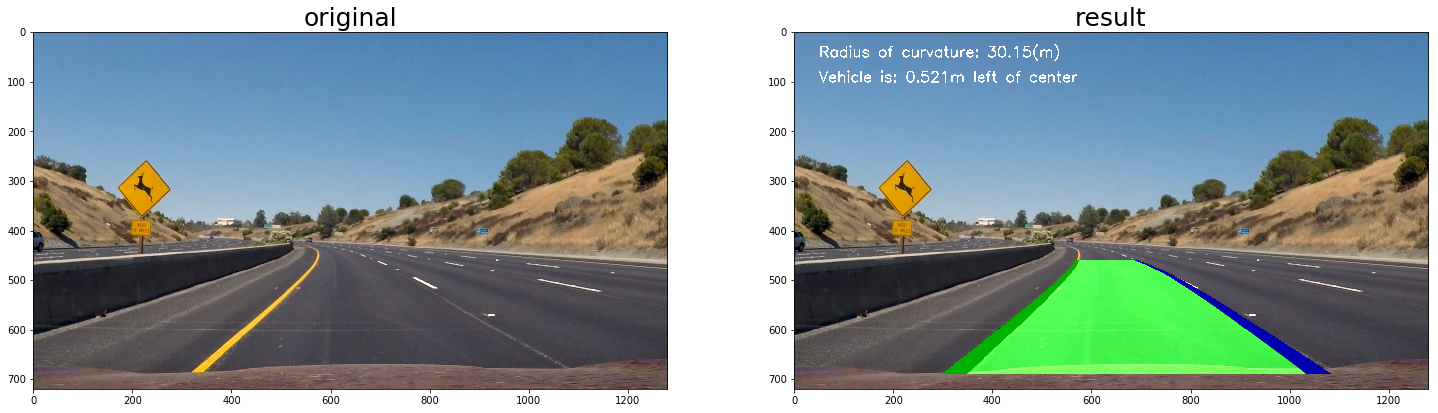

In [51]:
%matplotlib inline

test_img = mpimg.imread('./test_images/test2.jpg')
result = lane_finding_pipeline(test_img)

plt.figure(figsize=(25,10))
plt.subplot(121), plt.imshow(test_img), plt.title('original', fontsize=25)
plt.subplot(122), plt.imshow(result, cmap='gray'), plt.title('result', fontsize=25)

# Test entire pipeline on all test images

lane detected


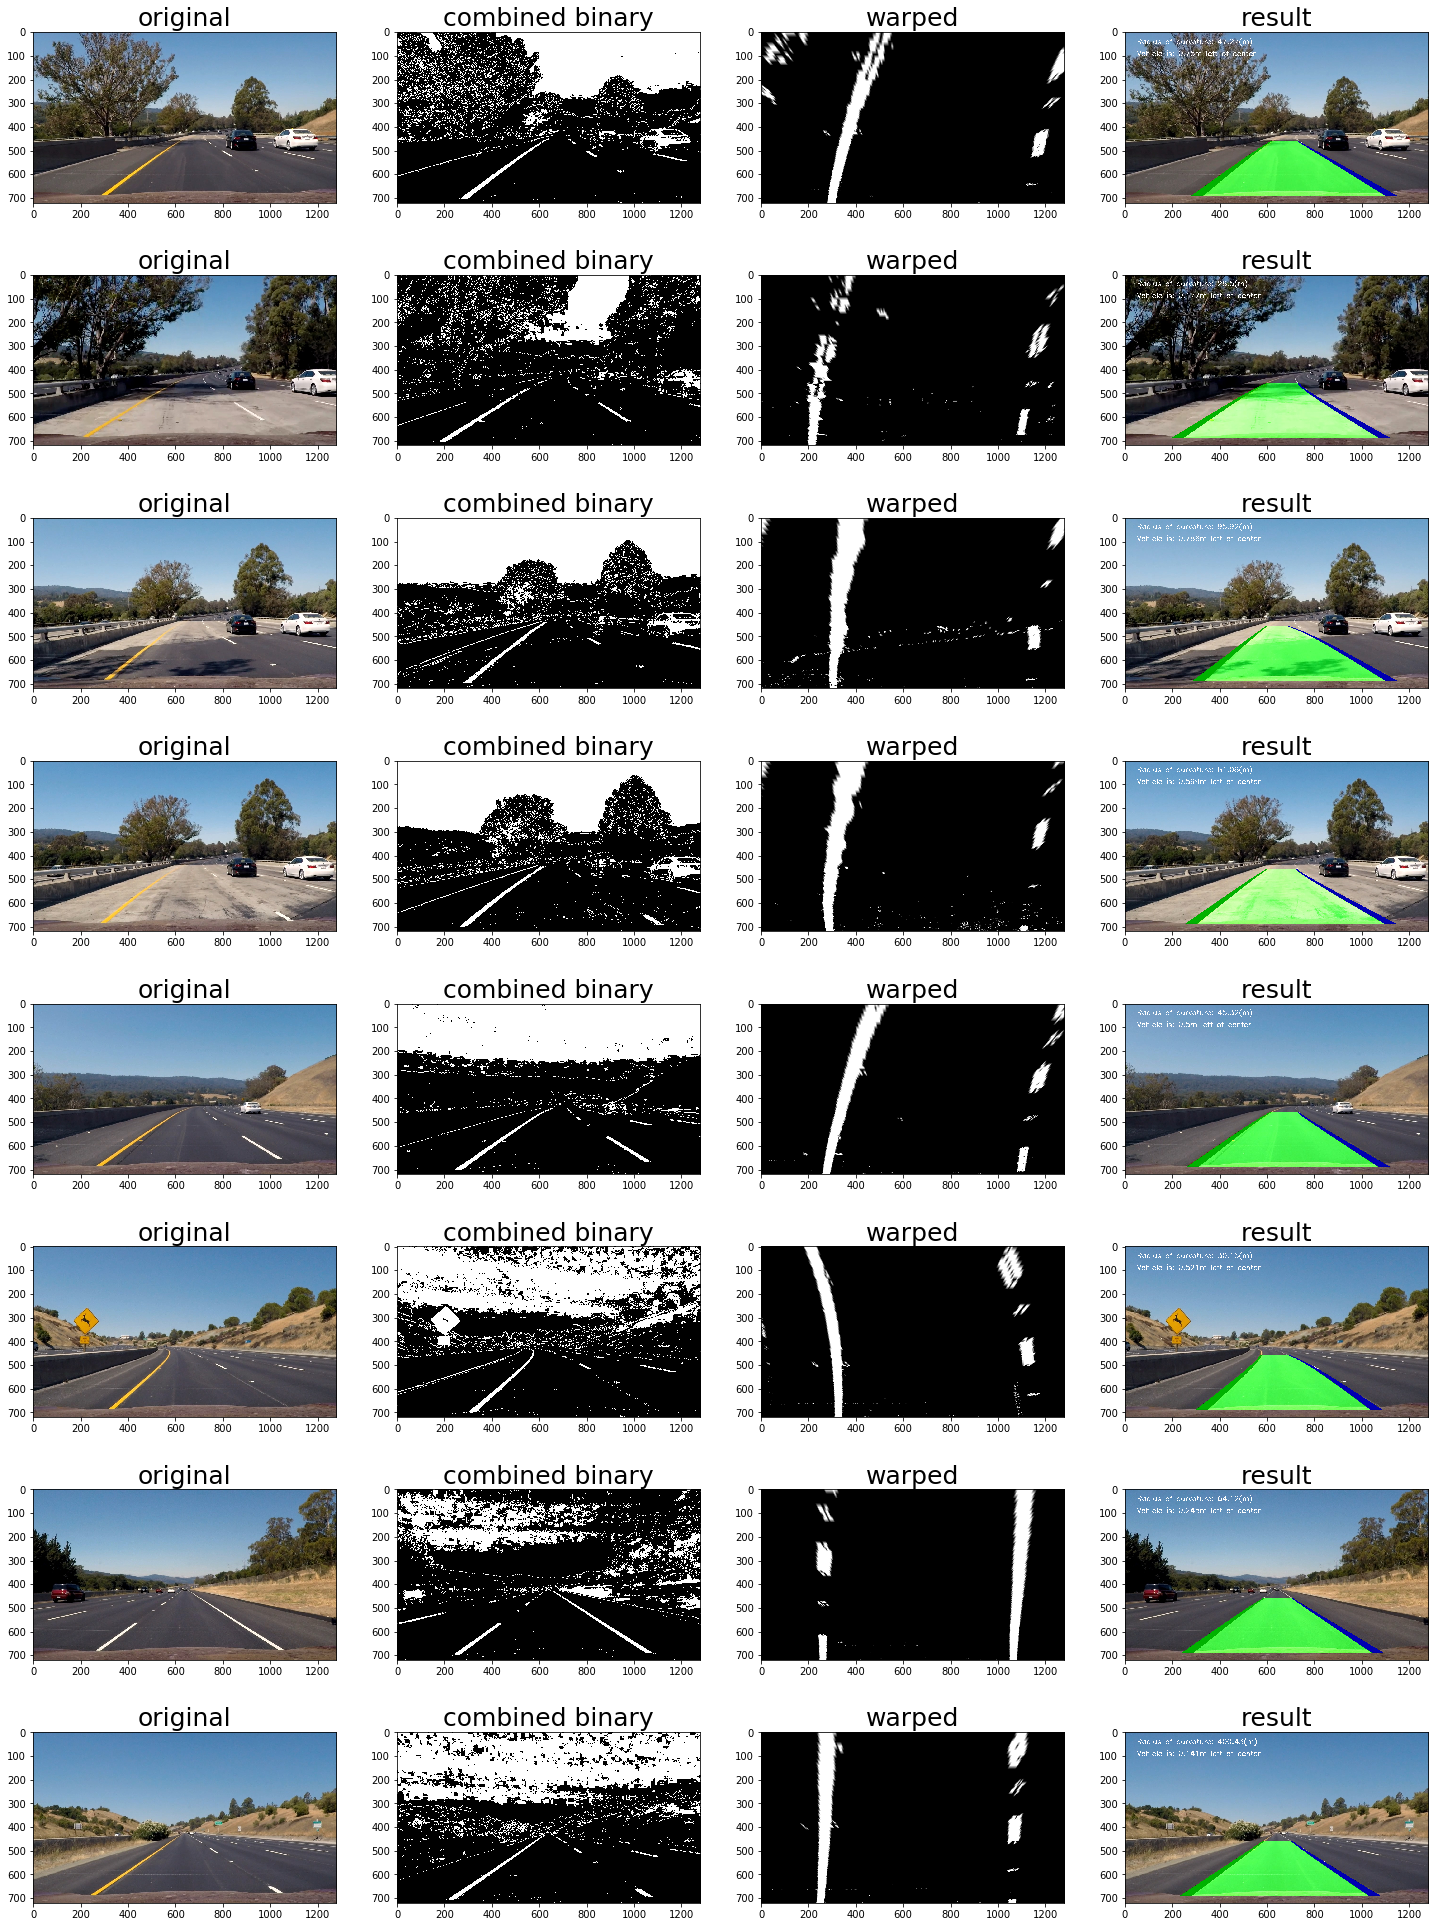

In [52]:
test_images = glob.glob('./test_images/*.jpg')

fig, ax = plt.subplots(8, 4, figsize=(25,35))
for i, fname in enumerate(test_images):
    img = mpimg.imread(fname)
    # preprocess images
    undist, color_bin, combined_bin, warped, _ = img_preprocessing_pipeline(img, mtx, dist, viz=True)
    # run entire pipeline
    result = lane_finding_pipeline(img)
    j = 0
    ax[i][j].imshow(img), ax[i][j].set_title('original', fontsize=25)
    ax[i][j+1].imshow(combined_bin, cmap='gray'), ax[i][j+1].set_title('combined binary', fontsize=25)
    ax[i][j+2].imshow(warped, cmap='gray'), ax[i][j+2].set_title('warped', fontsize=25)
    ax[i][j+3].imshow(result, cmap='gray'), ax[i][j+3].set_title('result', fontsize=25)

print('lane detected')

## Run Lane finding pipeline on project video

In [42]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

# on project_video
input_video = 'project_video.mp4'
output_video = 'project_video_tracked.mp4'

# input_clip = VideoFileClip(input_video, audio=False).subclip(27,30)
input_clip = VideoFileClip(input_video, audio=False)
output_clip = input_clip.fl_image(lane_finding_pipeline)
# %time
output_clip.write_videofile(output_video, audio=False)

[MoviePy] >>>> Building video project_video_tracked.mp4
[MoviePy] Writing video project_video_tracked.mp4


100%|█████████▉| 1260/1261 [06:20<00:00,  3.45it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_tracked.mp4 



In [44]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_video))